In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint

sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [2]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [3]:
set_directory_in_project()
# data_dir = "./data"
data_dir = "./smoothed_data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /home/bryanpu1/projects/adaptive_time
['hopper-v3', 'swimmer-v3', 'cheetah-v3', 'ant-v3']


In [4]:
# prefixes = ["uniform", "adaptive"]
prefixes = ["uniform-smoothed_data", "adaptive-smoothed_data"]
# prefixes = ["uniform"]

agg_results_per_prefix = {}
samplers_per_prefix = {}
for prefix in prefixes:
    if prefix.startswith("uniform"):
        sampler_constructor = approx_integrators.UniformlySpacedIntegrator
    elif prefix.startswith("adaptive"):
        sampler_constructor = approx_integrators.AdaptiveQuadratureIntegrator
    else:
        raise NotImplementedError
    agg_results_per_prefix[prefix] = pickle.load(open("./{}-combined_mujoco_val_est.pkl".format(prefix), "rb"))
    samplers_per_prefix[prefix] = {
        hyperparam: sampler_constructor(hyperparam) for hyperparam in agg_results_per_prefix[prefix]["ant-v3"]["approx_integrals"]
    }

# Sample trajectories and estimate values

In [5]:
update_budget = 1_000_000
sample_block = 1_000_000
num_seeds = 10

est_results = {}

for prefix, agg_results in agg_results_per_prefix.items():
    print(prefix)
    est_results[prefix] = {}
    samplers_tried = samplers_per_prefix[prefix]

    for env_name in agg_results:
        vals_per_state = np.concatenate(
            [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
        )
        print(vals_per_state.shape)

        approx_integrals = agg_results[env_name]["approx_integrals"]
        num_pivots = agg_results[env_name]["num_pivots"]

        weights = np.ones(len(vals_per_state)) / len(vals_per_state)
        true_value = np.sum(weights * vals_per_state)

        est_results[prefix][env_name] = {
            "weights": weights,
            "true_value": true_value,
            "runs": []
        }

        for seed in tqdm(range(num_seeds)):
            estimated_values_by_episode = {}
            number_of_pivots_by_episode = {}
            all_values_by_episode = {}

            rng = np.random.RandomState(seed)
            start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

            for sampler_name, sampler in samplers_tried.items():
                # print("sampler_name:", sampler_name)
                # Update the value estimate with new samples until we run out of budget.
                used_updates = 0
                value_estimate = 0
                num_episodes = 0
                all_values_by_episode[sampler_name] = []

                estimated_values_by_episode[sampler_name] = []
                number_of_pivots_by_episode[sampler_name] = []

                # pbar = tqdm(total = update_budget)
                while used_updates < update_budget:
                    num_episodes += 1
                    if num_episodes % sample_block == 0:
                        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                    start_state = start_states[(num_episodes - 1) % sample_block]
                    val_sample = approx_integrals[sampler_name][start_state]
                    all_values_by_episode[sampler_name].append(val_sample)
                    
                    value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                    used_updates += num_pivots[sampler_name][start_state]

                    estimated_values_by_episode[sampler_name].append(value_estimate)
                    number_of_pivots_by_episode[sampler_name].append(used_updates)
                #     pbar.update(num_pivots[sampler_name][start_state])
                # pbar.close()
            est_results[prefix][env_name]["runs"].append({
                "estimated_values_by_episode": estimated_values_by_episode,
                "number_of_pivots_by_episode": number_of_pivots_by_episode,
                "all_values_by_episode": all_values_by_episode,
            })


uniform-smoothed_data
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

adaptive-smoothed_data
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

# Compile plot statistics using interpolation

In [6]:
def process_across_runs(
    runs,
    samplers_tried,
    true_value,
):
    results = {}
    for sampler in samplers_tried:
        interpolated_results = np.zeros((len(runs), update_budget + 1))
        for run_i, run in enumerate(runs):
            number_of_pivots_by_episode = run["number_of_pivots_by_episode"][sampler]
            estimated_values_by_episode = run["estimated_values_by_episode"][sampler]

            interpolated_results[run_i] = np.interp(
                np.arange(update_budget + 1),
                number_of_pivots_by_episode,
                np.abs(estimated_values_by_episode - true_value)[:number_of_pivots_by_episode[-1]]
            )
        results[sampler] = interpolated_results
    return results

In [8]:

plot_stats = {}
for prefix, curr_result in est_results.items():
    print(prefix)
    samplers_tried = samplers_per_prefix[prefix]
    plot_stats[prefix] = {}
    for env_i, env_name in enumerate(tqdm(curr_result)):
        true_value = curr_result[env_name]["true_value"]
        env_result = process_across_runs(
            curr_result[env_name]["runs"],
            samplers_tried,
            true_value
        )
        plot_stats[prefix][env_name] = env_result

uniform-smoothed_data


  0%|          | 0/4 [00:00<?, ?it/s]

adaptive-smoothed_data


  0%|          | 0/4 [00:00<?, ?it/s]

# Plot error vs number of updates

## Plot aggregated result

In [9]:
# s_to_plot = ["q1", "q10", "q100", "u1", "u10", "u500"]
# s_to_plot = ["q0", "u1"]
# s_to_plot = samplers_tried.keys()
plot_this = False
if plot_this:
    ncols = 3
    fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

    start_idx = 0
    end_idx = 1_000_000
    for env_i, env_name in enumerate(env_names):
        ax = axes[env_i // ncols, env_i % ncols]
        for prefix in prefixes:
            env_result = plot_stats[prefix][env_name]
            samplers_tried = samplers_per_prefix[prefix]
            for s in tqdm(samplers_tried):
                y_means = np.nanmean(env_result[s][:, start_idx:end_idx], axis=0)
                y_stderrs = np.nanstd(env_result[s][:, start_idx:end_idx], axis=0) / np.sqrt(num_seeds)
                x_range = np.arange(update_budget + 1)[start_idx:end_idx]

                y_means = np.log10(y_means, out=np.zeros_like(y_means), where=(y_means != 0))
                y_stderrs = np.log10(y_stderrs, out=np.zeros_like(y_stderrs), where=(y_stderrs != 0))

                ax.plot(
                    x_range,
                    y_means,
                    label=s if env_i == 0 else ""
                )
                ax.fill_between(
                    x_range,
                    (y_means - y_stderrs),
                    (y_means + y_stderrs),
                    alpha=0.1
                )
        ax.set_title("Env: {}".format(env_name))

    fig.supylabel("Error in value estimate")
    fig.supxlabel("Number of Samples")
    fig.legend()
    plt.show()

# Plot error vs hyperparameter (i.e. tolerance/discretization)

In [10]:
budgets_to_check_per_env = {
    "inverted_double_pendulum-v2": (25000, np.array([2, 5, 10, 20, 40])),
    "swimmer-v3": (20000, np.array([2, 5, 10, 20, 40])),
    "hopper-v3": (8000, np.array([2, 5, 10, 20, 40])),
    "ant-v3": (25000, np.array([2, 5, 10, 20, 40])),
    "cheetah-v3": (25000, np.array([2, 5, 10, 20, 40])),
    "pusher-v2": (25000, np.array([2, 5, 10, 20, 40])),
}

# Approximate horizon for adaptive method for "same mapping"

In [11]:
print(agg_results.keys())

dict_keys(['swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3'])


In [12]:
print(agg_results_per_prefix.keys())

dict_keys(['uniform-smoothed_data', 'adaptive-smoothed_data'])


In [17]:
adaptive_prefix = "adaptive-smoothed_data"

tolerances = np.power(10, np.arange(-2.0, 4.0, 1.0)) * 5
samplers_tried = {
    "q{}".format(tolerance): approx_integrators.AdaptiveQuadratureIntegrator(tolerance=tolerance) for tolerance in tolerances
}

tau_to_h = {}
for env_i, env_name in enumerate(env_names):
    traj_len = 40000 if env_name == "swimmer-v3" else 50000
    env_result = plot_stats[adaptive_prefix][env_name]
    num_pivots = agg_results_per_prefix[adaptive_prefix][env_name]["num_pivots"]
    tau_to_h[env_name] = np.array([
        (sampler, math.ceil(np.mean(traj_len / num_pivots[sampler]))) for sampler in num_pivots
    ])

hopper-v3
8000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

8000
[['q0.125' '41']
 ['q0.1767766952966369' '46']
 ['q0.25' '56']
 ['q0.3535533905932738' '65']
 ['q0.5' '80']
 ['q0.7071067811865476' '92']
 ['q1.0' '110']
 ['q1.4142135623730951' '128']
 ['q2.0' '160']
 ['q2.8284271247461903' '180']
 ['q4.0' '222']
 ['q5.656854249492381' '259']
 ['q8.0' '320']
 ['q11.313708498984761' '358']
 ['q16.0' '431']
 ['q22.627416997969522' '504']
 ['q32.0' '647']
 ['q45.254833995939045' '722']
 ['q64.0' '888']
 ['q90.50966799187809' '1040']
 ['q128.0' '1296']
 ['q181.01933598375618' '1462']
 ['q256.0' '2001']
 ['q362.03867196751236' '2381']
 ['q512.0' '3184']
 ['q1024.0' '3334']
 ['q724.0773439350247' '3334']
 ['q1448.1546878700494' '3844']
 ['q2048.0' '3847']
 ['q2896.309375740099' '3847']
 ['q4096.0' '6227']]


  0%|          | 0/5 [00:00<?, ?it/s]

swimmer-v3
20000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

20000
[['q0.125' '53']
 ['q0.1767766952966369' '62']
 ['q0.25' '74']
 ['q0.3535533905932738' '88']
 ['q0.5' '105']
 ['q0.7071067811865476' '125']
 ['q1.0' '148']
 ['q1.4142135623730951' '175']
 ['q2.0' '210']
 ['q2.8284271247461903' '251']
 ['q4.0' '298']
 ['q5.656854249492381' '354']
 ['q8.0' '424']
 ['q11.313708498984761' '504']
 ['q16.0' '597']
 ['q22.627416997969522' '710']
 ['q32.0' '852']
 ['q45.254833995939045' '1009']
 ['q64.0' '1193']
 ['q90.50966799187809' '1428']
 ['q128.0' '1634']
 ['q181.01933598375618' '1913']
 ['q256.0' '2200']
 ['q362.03867196751236' '2449']
 ['q512.0' '2788']
 ['q724.0773439350247' '3334']
 ['q1024.0' '3558']
 ['q1448.1546878700494' '4145']
 ['q2048.0' '6262']
 ['q2896.309375740099' '10599']
 ['q4096.0' '13293']]


  0%|          | 0/5 [00:00<?, ?it/s]

cheetah-v3
25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

25000
[['q0.125' '16']
 ['q0.1767766952966369' '18']
 ['q0.25' '22']
 ['q0.3535533905932738' '26']
 ['q0.5' '31']
 ['q0.7071067811865476' '36']
 ['q1.0' '43']
 ['q1.4142135623730951' '52']
 ['q2.0' '62']
 ['q2.8284271247461903' '72']
 ['q4.0' '85']
 ['q5.656854249492381' '104']
 ['q8.0' '124']
 ['q11.313708498984761' '143']
 ['q16.0' '169']
 ['q22.627416997969522' '208']
 ['q32.0' '247']
 ['q45.254833995939045' '286']
 ['q64.0' '337']
 ['q90.50966799187809' '414']
 ['q128.0' '491']
 ['q181.01933598375618' '563']
 ['q256.0' '669']
 ['q362.03867196751236' '830']
 ['q512.0' '966']
 ['q724.0773439350247' '1129']
 ['q1024.0' '1275']
 ['q1448.1546878700494' '1547']
 ['q2048.0' '1907']
 ['q2896.309375740099' '2121']
 ['q4096.0' '2584']]


  0%|          | 0/5 [00:00<?, ?it/s]

ant-v3
25000
[['u2' '2']
 ['u3' '3']
 ['u4' '4']
 ['u5' '5']
 ['u6' '6']
 ['u8' '8']
 ['u9' '9']
 ['u11' '11']
 ['u13' '13']
 ['u16' '16']
 ['u19' '19']
 ['u22' '22']
 ['u26' '26']
 ['u32' '32']
 ['u38' '38']
 ['u45' '45']
 ['u53' '53']
 ['u64' '64']
 ['u76' '76']
 ['u90' '90']
 ['u107' '107']
 ['u128' '128']
 ['u152' '152']
 ['u181' '181']
 ['u215' '215']
 ['u256' '256']
 ['u304' '304']
 ['u362' '362']
 ['u430' '430']
 ['u512' '512']
 ['u608' '608']
 ['u724' '724']
 ['u861' '861']
 ['u1024' '1024']
 ['u1217' '1217']
 ['u1448' '1448']
 ['u1722' '1722']
 ['u2048' '2048']
 ['u2435' '2435']
 ['u2896' '2896']
 ['u3444' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

25000
[['q0.125' '25']
 ['q0.1767766952966369' '30']
 ['q0.25' '35']
 ['q0.3535533905932738' '43']
 ['q0.5' '51']
 ['q0.7071067811865476' '60']
 ['q1.0' '71']
 ['q1.4142135623730951' '86']
 ['q2.0' '102']
 ['q2.8284271247461903' '120']
 ['q4.0' '142']
 ['q5.656854249492381' '170']
 ['q8.0' '202']
 ['q11.313708498984761' '238']
 ['q16.0' '282']
 ['q22.627416997969522' '334']
 ['q32.0' '398']
 ['q45.254833995939045' '477']
 ['q64.0' '568']
 ['q90.50966799187809' '677']
 ['q128.0' '814']
 ['q181.01933598375618' '966']
 ['q256.0' '1150']
 ['q362.03867196751236' '1382']
 ['q512.0' '1653']
 ['q724.0773439350247' '1969']
 ['q1024.0' '2342']
 ['q1448.1546878700494' '2808']
 ['q2048.0' '3342']
 ['q2896.309375740099' '3904']
 ['q4096.0' '4451']]


  0%|          | 0/5 [00:00<?, ?it/s]

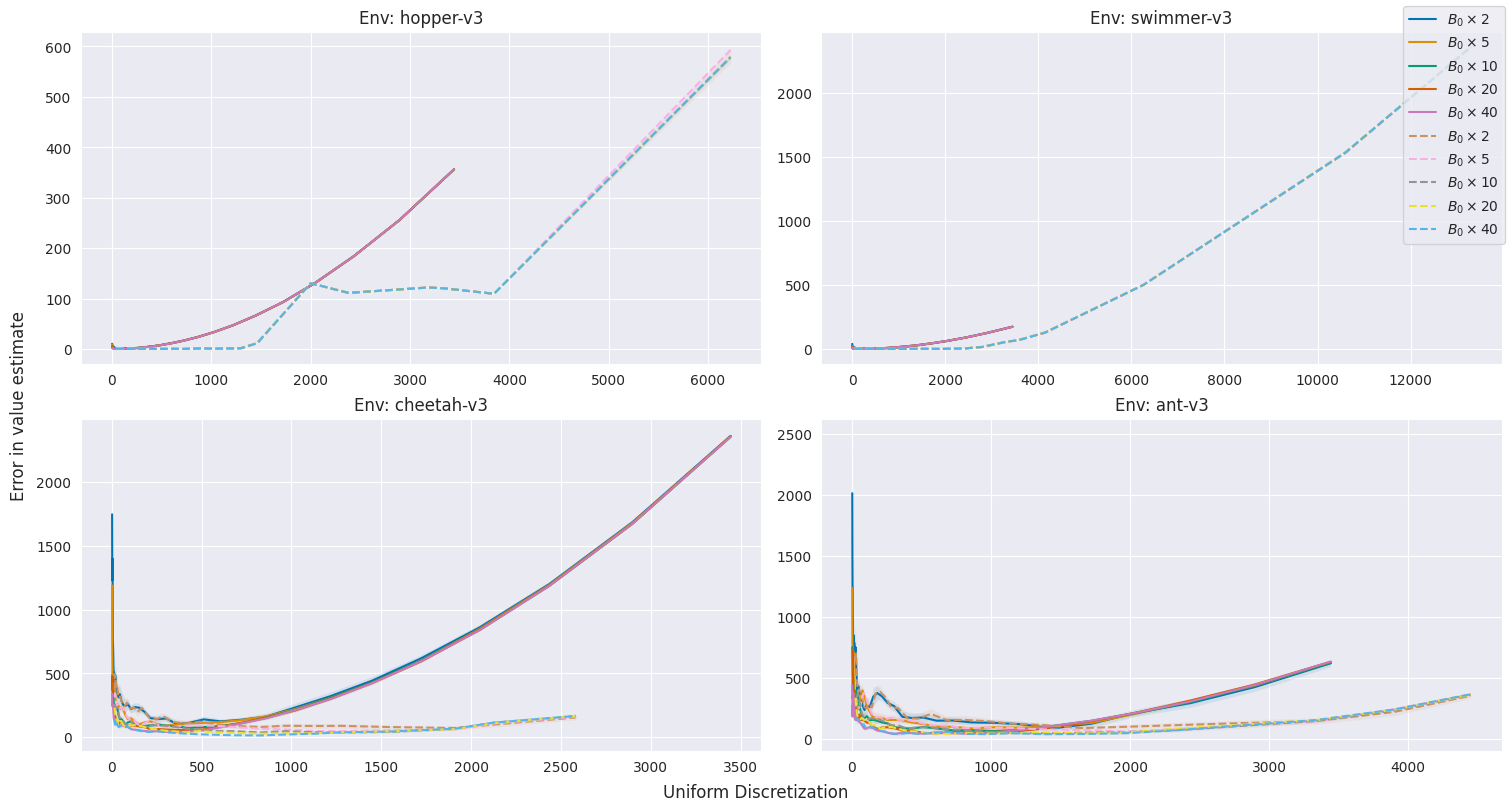

In [19]:
ncols = 2
fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

for env_i, env_name in enumerate(env_names):
    print(env_name)
    for prefix in prefixes:
    # for prefix in ["adaptive", "uniform"]:
    # for prefix in ["adaptive"]:
        if prefix.startswith("uniform"):
            spacing_keys = np.array(list(samplers_per_prefix[prefix].keys()))
            spacing = np.array([int(key[1:]) for key in spacing_keys])
            sorted_idxes = np.argsort(spacing)
            sorted_spacing = spacing[sorted_idxes]
            sorted_keys = ["u{}".format(item) for item in sorted_spacing]
        elif prefix.startswith("adaptive"):
            sorted_idxes = np.argsort(tau_to_h[env_name][:, 1].astype(int))
            sorted_spacing = tau_to_h[env_name][:, 1][sorted_idxes].astype(int)
            sorted_keys = tau_to_h[env_name][:, 0][sorted_idxes]
        else:
            raise NotImplementedError

        env_result = plot_stats[prefix][env_name]
        ax = axes[env_i // ncols, env_i % ncols]

        base_budget, multipliers = budgets_to_check_per_env[env_name]
        print(base_budget)
        print(np.vstack((sorted_keys, sorted_spacing)).T)
        for multiplier in tqdm(multipliers):
            idx = int(base_budget * multiplier)
            y_means = []
            y_stderrs = []
            for s in sorted_keys:
                y_means.append(np.nanmean(env_result[s][:, idx]))
                y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                sorted_spacing,
                y_means,
                label="$B_0 \\times {}$".format(multiplier) if env_i == 0 else "",
                linestyle="-" if prefix.startswith("uniform") else "--"
            )
            ax.fill_between(
                sorted_spacing,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )
            ax.set_title("Env: {}".format(env_name))
            # ax.set_xlim(-10, 4000)

fig.supylabel("Error in value estimate")
fig.supxlabel("Uniform Discretization")
fig.legend()
plt.show()

In [21]:
pprint([(env_name, data["true_value"]) for env_name, data in est_results["adaptive-smoothed_data"].items()])

[('swimmer-v3', 14139.142459602244),
 ('hopper-v3', 59060.05022411215),
 ('ant-v3', 124009.37298112924),
 ('cheetah-v3', 269098.2525996715)]


In [ ]:
# data = np.load("./data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy")
# data = np.load("./data/ant-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/hopper-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/cheetah-v3/Rewards_50000_1000_0.npy")
# data = np.load("./data/pusher-v2/Rewards_50000_1000_0.npy")
data = np.load("./data/swimmer-v3/Rewards_40000_1000_0.npy")

In [ ]:
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
x_range = np.arange(data.shape[1])
plt.plot(x_range, mean)
# plt.fill_between(x_range, mean - std, mean + std, alpha=0.1)
# plt.ylim(9.358, 9.362)
plt.show()
print(np.mean(np.sum(data, axis=1)))

In [ ]:
agg_results_per_prefix["adaptive"]["swimmer-v3"]["num_pivots"]

In [ ]:
agg_results_per_prefix["adaptive"]["swimmer-v3"]["reward_file"]

In [ ]:
data = np.load("./{}/ant-v3/Rewards_50000_1000_8-smoothed.npy".format(data_dir))

In [ ]:
ncols = 4
fig, axes = plt.subplots(nrows=5, ncols=ncols, figsize=(25, 15), layout="constrained")

for traj_i in range(20):
    ax = axes[traj_i // ncols, traj_i % ncols]
    ax.plot(data.T[traj_i])
plt.show()

In [ ]:
np.sum(data.T[0])